# Project 3 : Dynamic COVID-19 Spreading Control via Permissive Population Mobility Policies - Mobility Model Team


NJIT Data Science Program
Course
CS634 Data Mining - Summer 2020

Instructor
Pantelis Monogioudis, Ph.D Professor of Practice, NJIT & Adjunct NYU

Teaching Assistant
Michael Lam (PhD student)

Students:

*   Fernando Rios
*   Hassan Ouanir
*   Ian Kavuma
*   Adish Vakharia



# Libraries

In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Loading training dataset

In [ ]:
# Path of training data file in Google Drive (each group will modify the path of its traininig file)
# path_csv = "/content/drive/My Drive/Colab Notebooks/AgentBasedModelling/training_data.csv"
path_csv = "/content/drive/My Drive/Notebooks/Mobility/training_data.csv"

In [ ]:
# This function mount google colab and, read training file csv, returns a dataframe
def ds_from_googlecolab(path_csv):
  from google.colab import drive
  drive.mount('/content/drive')
  ds = pd.read_csv(path_csv)
  return ds

In [ ]:
# Called to the function above mentioned to bring the training dataframe with the 5 first rows.
df_train = ds_from_googlecolab(path_csv)
df_train.head()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,key,month,hour,minute,pickup_grid_number,dropoff_grid_number
0,2013-07-02 19:54:00.000000232,7,19,54,34.0,7.0
1,2009-07-22 16:08:00.000000163,7,16,8,230.0,85.0
2,2010-07-07 14:52:00.00000044,7,14,52,650.0,850.0
3,2012-07-18 00:16:00.00000083,7,0,16,264.0,217.0
4,2012-07-19 23:53:14.0000002,7,23,53,72.0,660.0


In [ ]:
# Understanding the shape of the training dataset

In [ ]:
print("Rows:", df_train.shape[0], "Columns:", df_train.shape[1])

Rows: 3414443 Columns: 6


# Verifying empty values

In [ ]:
# Finding empty values over the columns used in the project.
def num_of_empty(ds):
  ds_empty= ds.loc[(ds['pickup_grid_number']=='') | (ds['dropoff_grid_number']=='') | (ds['hour']=='')]
  return ds_empty.shape[0]

In [ ]:
num_row_empty = num_of_empty(df_train)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
print("Number of row with empty values: ", num_row_empty)

Number of row with empty values:  0


In [ ]:
df_train.describe()

,month,hour,minute,pickup_grid_number,dropoff_grid_number
count,3414443.0,3.414443e+06,3.414443e+06,3.414443e+06,3.414443e+06
mean,7.0,1.363001e+01,2.959339e+01,3.449561e+02,3.690503e+02
std,0.0,6.460319e+00,1.734916e+01,2.693562e+02,3.083107e+02
min,7.0,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
25%,7.0,9.000000e+00,1.500000e+01,1.400000e+02,1.470000e+02
50%,7.0,1.400000e+01,3.000000e+01,2.860000e+02,2.970000e+02
75%,7.0,1.900000e+01,4.500000e+01,4.810000e+02,4.950000e+02
max,7.0,2.300000e+01,5.900000e+01,2.500000e+03,2.500000e+03


We can observe in the table, the dataset has trips just of month 7. The feature hour looks well, the minimum is 0 and maximum is 23 hour. Minutes looks good as well, from 0 minutes to 59 minutes. Pickup has trips from zone 0 to zone 2500, clearly skewed right with a mean of zone 344. Dropoff has trips from zone 0 to 2500, clearly skewed right as well with a mean of zone 369.

# Creating General Matrix Pickup vs Dropoff

This matrix generates the number of trips by zones

In [ ]:
matrix = df_train.groupby(['pickup_grid_number','dropoff_grid_number']).size().unstack().fillna(0)
matrix

dropoff_grid_number,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,...,2040.0,2047.0,2050.0,2064.0,2070.0,2075.0,2088.0,2090.0,2093.0,2100.0,2112.0,2116.0,2125.0,2136.0,2139.0,2150.0,2160.0,2162.0,2175.0,2184.0,2200.0,2208.0,2225.0,2232.0,2250.0,2256.0,2275.0,2280.0,2300.0,2304.0,2325.0,2328.0,2350.0,2375.0,2376.0,2400.0,2425.0,2450.0,2475.0,2500.0
pickup_grid_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0,17.0,5.0,1.0,1.0,3.0,4.0,10.0,2.0,4.0,0.0,3.0,1.0,5.0,3.0,1.0,0.0,8.0,0.0,2.0,3.0,2.0,1.0,3.0,2.0,4.0,5.0,5.0,0.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,1.0,2.0,57.0,14.0,14.0,19.0,21.0,42.0,22.0,44.0,20.0,54.0,21.0,31.0,13.0,21.0,9.0,22.0,11.0,34.0,17.0,15.0,10.0,52.0,29.0,42.0,18.0,30.0,7.0,34.0,18.0,44.0,11.0,8.0,2.0,51.0,0.0,8.0,13.0,38.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,1.0,3.0,14.0,59.0,10.0,10.0,17.0,36.0,28.0,58.0,18.0,55.0,36.0,33.0,15.0,18.0,5.0,20.0,6.0,31.0,17.0,23.0,20.0,53.0,43.0,65.0,14.0,37.0,9.0,40.0,8.0,49.0,14.0,8.0,2.0,58.0,0.0,6.0,20.0,41.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,3.0,10.0,6.0,36.0,17.0,4.0,22.0,18.0,33.0,9.0,45.0,43.0,24.0,11.0,10.0,6.0,12.0,0.0,25.0,9.0,22.0,10.0,34.0,16.0,35.0,12.0,21.0,4.0,21.0,8.0,15.0,4.0,10.0,1.0,28.0,0.0,7.0,15.0,21.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2425.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2450.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# Understanding shape of the matrix
matrix.shape

(957, 979)

We find 957 pickup zones by 979 dropoff zones used in the all trips

# Calculating Number of trips in the same zone

In [ ]:
# This function return a tuple with the trips from a zone to the same zone.
def same_zone(matriz):
  res = []
  v_cols= matriz.columns
  v_rows= matriz.index
  for i in v_cols:
    for j in v_rows:
      if (i==j):
        res.append((i,matriz[i][j]))
  return (res)

In [ ]:
# Calling the function same_zone given the matrix.
resul = same_zone(matrix)
resul

[(1.0, 2.0),
 (2.0, 17.0),
 (3.0, 57.0),
 (4.0, 59.0),
 (5.0, 36.0),
 (6.0, 73.0),
 (7.0, 100.0),
 (8.0, 159.0),
 (9.0, 77.0),
 (10.0, 216.0),
 (11.0, 37.0),
 (12.0, 147.0),
 (13.0, 36.0),
 (14.0, 101.0),
 (15.0, 57.0),
 (16.0, 161.0),
 (17.0, 56.0),
 (18.0, 136.0),
 (19.0, 20.0),
 (20.0, 129.0),
 (21.0, 81.0),
 (22.0, 85.0),
 (23.0, 55.0),
 (24.0, 194.0),
 (25.0, 68.0),
 (26.0, 184.0),
 (27.0, 85.0),
 (28.0, 152.0),
 (29.0, 29.0),
 (30.0, 130.0),
 (31.0, 23.0),
 (32.0, 149.0),
 (33.0, 39.0),
 (34.0, 63.0),
 (35.0, 10.0),
 (36.0, 187.0),
 (37.0, 3.0),
 (38.0, 54.0),
 (39.0, 40.0),
 (40.0, 134.0),
 (41.0, 0.0),
 (42.0, 133.0),
 (43.0, 2.0),
 (44.0, 129.0),
 (45.0, 79.0),
 (46.0, 102.0),
 (47.0, 5.0),
 (48.0, 778.0),
 (49.0, 5.0),
 (50.0, 283.0),
 (51.0, 117.0),
 (52.0, 256.0),
 (53.0, 0.0),
 (54.0, 256.0),
 (55.0, 35.0),
 (56.0, 178.0),
 (57.0, 101.0),
 (58.0, 79.0),
 (59.0, 0.0),
 (60.0, 525.0),
 (62.0, 38.0),
 (63.0, 88.0),
 (64.0, 115.0),
 (65.0, 91.0),
 (66.0, 154.0),
 (68.0, 101.0)

In [ ]:
# This function searches in the tuple the area with the most trips.
def Max_SameZone(tuple):
  return max(tuple,key=lambda zone:zone[1])

In [ ]:
# Calling to the function Max_SameZone
print("Zone:", Max_SameZone(resul)[0], "Number of trips:", Max_SameZone(resul)[1])

Zone: 805.0 Number of trips: 1102.0


In [ ]:
# This function searches in the tuple the area with the fewest trips.
def Min_SameZone(tuple):
  return min(tuple,key=lambda zone:zone[1])

In [ ]:
# Calling to the function Min_SameZone
print("Zone:", Min_SameZone(resul)[0], "Number of trips:", Min_SameZone(resul)[1])

Zone: 41.0 Number of trips: 0.0


In [ ]:
# This function sort the tuple ascendent or descendent
def Sort_Tuple(tup,asc):
  if type(asc)==bool:
    if asc==True: 
      return(sorted(tup, key = lambda x: x[1])) 
    else:
      return(sorted(tup, key = lambda x: -x[1]))
  else:
    print("Parameter asc should be boolean")

In [ ]:
 # Printing the tuple ordered
 print(Sort_Tuple(resul,True)) # False is descendent , True is ascendent

[(41.0, 0.0), (53.0, 0.0), (59.0, 0.0), (141.0, 0.0), (177.0, 0.0), (188.0, 0.0), (236.0, 0.0), (268.0, 0.0), (284.0, 0.0), (295.0, 0.0), (299.0, 0.0), (335.0, 0.0), (343.0, 0.0), (355.0, 0.0), (371.0, 0.0), (426.0, 0.0), (427.0, 0.0), (469.0, 0.0), (488.0, 0.0), (497.0, 0.0), (549.0, 0.0), (590.0, 0.0), (610.0, 0.0), (639.0, 0.0), (670.0, 0.0), (671.0, 0.0), (730.0, 0.0), (732.0, 0.0), (737.0, 0.0), (747.0, 0.0), (781.0, 0.0), (804.0, 0.0), (847.0, 0.0), (869.0, 0.0), (871.0, 0.0), (902.0, 0.0), (923.0, 0.0), (938.0, 0.0), (962.0, 0.0), (986.0, 0.0), (989.0, 0.0), (996.0, 0.0), (1022.0, 0.0), (1034.0, 0.0), (1036.0, 0.0), (1065.0, 0.0), (1067.0, 0.0), (1095.0, 0.0), (1106.0, 0.0), (1110.0, 0.0), (1128.0, 0.0), (1162.0, 0.0), (1184.0, 0.0), (1185.0, 0.0), (1215.0, 0.0), (1258.0, 0.0), (1274.0, 0.0), (1292.0, 0.0), (1325.0, 0.0), (1326.0, 0.0), (1335.0, 0.0), (1340.0, 0.0), (1343.0, 0.0), (1349.0, 0.0), (1376.0, 0.0), (1387.0, 0.0), (1404.0, 0.0), (1420.0, 0.0), (1460.0, 0.0), (1470.0, 

In [ ]:
# Getting 5 high demand zones, picking and dropping in the same zone.
FiveTuple=Sort_Tuple(resul,False)[:5]
FiveTuple

[(805.0, 1102.0),
 (180.0, 970.0),
 (360.0, 868.0),
 (540.0, 809.0),
 (48.0, 778.0)]

In [ ]:
# This functions gets only the zones
def Get_Zones(tuple):
  return [tuple_[0] for tuple_ in FiveTuple]

In [ ]:
# This functions gets only the number of trips
def Get_NumTrips(tuple):
  return [tuple_[1] for tuple_ in FiveTuple]

In [ ]:
# Retriving Zones and values of the 5 high demand zones, picking and dropping in the same zone.
Zones=Get_Zones(FiveTuple)
Values=Get_NumTrips(FiveTuple)
Zones, Values

([805.0, 180.0, 360.0, 540.0, 48.0], [1102.0, 970.0, 868.0, 809.0, 778.0])

In [ ]:
# Function that create a barchart with the high demand in the same zone
def barchart(tuple):
  objects = Get_Zones(FiveTuple)
  y_pos = np.arange(len(objects))
  performance = Get_NumTrips(FiveTuple)

  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.xlabel('Zones')
  plt.ylabel('# trips')
  plt.title('High Demand in the same zone')

  plt.show()

In [ ]:
# Tuple ordered to show it in the barchart
FiveGreatest=Sort_Tuple(resul,False)[:5]
FiveGreatest

[(805.0, 1102.0),
 (180.0, 970.0),
 (360.0, 868.0),
 (540.0, 809.0),
 (48.0, 778.0)]

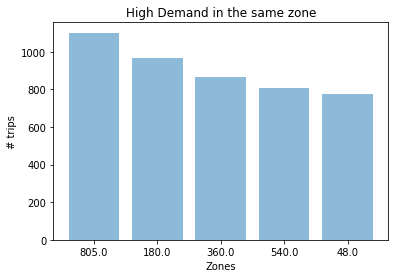

In [ ]:
# Calling to the function barchart to plot the 5 zones with high demand in trips, from / to same zone.
barchart(FiveGreatest)

The above graphic show us that the zone 805. People use this zone to pick up and dropoff.

# Total de trips given the zone

In [ ]:
# All pickup trips given zone
def pickup_by_zone(matriz,zone):
  sum_zone =matriz[matriz.index==zone].sum(axis=1)
  return sum_zone.values[0]

In [ ]:
# Example: How many pickup trips were in the zone 805
pickup_by_zone(matrix,805)

1318.0

This makes sense, because in the barchart showed lines above, we saw that zone 805 is the most used from / to same zone, this means that the difference between 1318 and 1102 are 216 trips, that were picked up from the zone 805 but the droppoff was in a different zone.

In [ ]:
# All dropoff trips given zone
def droppoff_by_zone(matriz,zone):
  return matriz[zone].sum()

In [ ]:
# Example: How many dropoff trips were in the zone 2500
droppoff_by_zone(matrix,2500)

48.0

In [ ]:
# All trips from / to zone
def total_zone(matriz,zonepickup, zonedropoff):
  total = pickup_by_zone(matriz,zonepickup)+droppoff_by_zone(matriz,zonedropoff)
  return total

In [ ]:
# Calculating all the trips that were picked up in the zone 1 and all the trips droppoff in the zone 1 
total_zone(matrix,1,1)

69.0






















# Creating matrix pickup vs dropoff by hours

In [ ]:
matrizbyhours = df_train.groupby(['hour','pickup_grid_number','dropoff_grid_number']).size().unstack().fillna(0)
matrizbyhours

dropoff_grid_number      1.0     2.0     3.0     ...  2450.0  2475.0  2500.0
hour pickup_grid_number                          ...                        
0    1.0                    0.0     0.0     0.0  ...     0.0     0.0     0.0
     2.0                    0.0     1.0     0.0  ...     0.0     0.0     0.0
     3.0                    0.0     0.0     4.0  ...     0.0     0.0     0.0
     4.0                    0.0     0.0     1.0  ...     0.0     0.0     0.0
     5.0                    0.0     0.0     0.0  ...     0.0     0.0     0.0
...                         ...     ...     ...  ...     ...     ...     ...
23   2232.0                 0.0     0.0     0.0  ...     0.0     0.0     0.0
     2256.0                 0.0     0.0     0.0  ...     0.0     0.0     0.0
     2275.0                 0.0     0.0     0.0  ...     0.0     0.0     0.0
     2350.0                 0.0     0.0     0.0  ...     0.0     0.0     0.0
     2450.0                 0.0     0.0     0.0  ...     0.0     0.0     0.0

[16738 rows x 979 columns]

# Data visualization

## Heatmap to visualize the zones of pickup and dropoff aggregated

In [ ]:
# This function create a heatmap to visualize the zones of pickup and dropoff, we give the matrix, width and height of the heatmap.
def plot(matriz,width,height):
  fig, ax = plt.subplots(figsize=(width,height)) 
  ax = sns.heatmap(matriz, 
      vmin=0, vmax=max(matriz.max()),
      cmap=sns.diverging_palette(20, 220, n=20),
      square=False,
  )
  ax.set_xticklabels(
      ax.get_xticklabels(),
      rotation=45,
      horizontalalignment='right'
  );

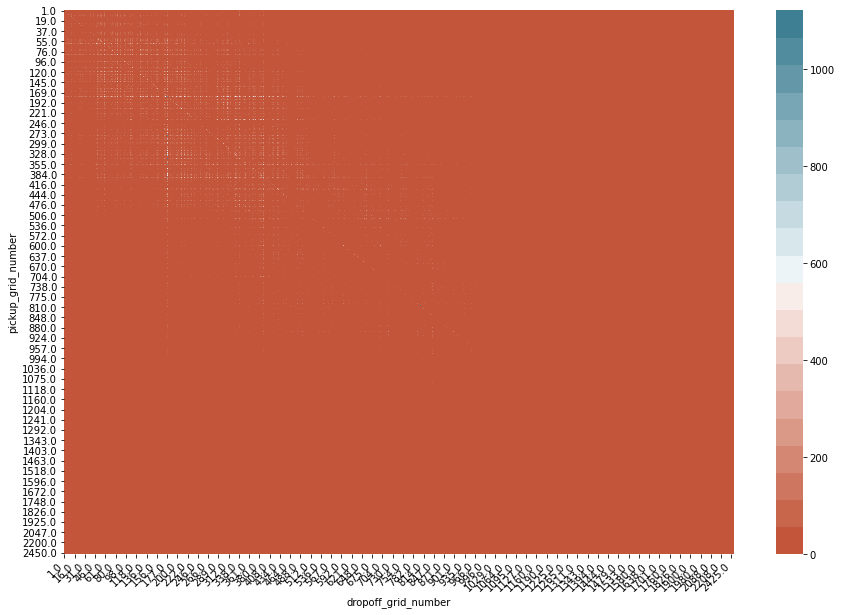

In [ ]:
plot(matrix,15,10)

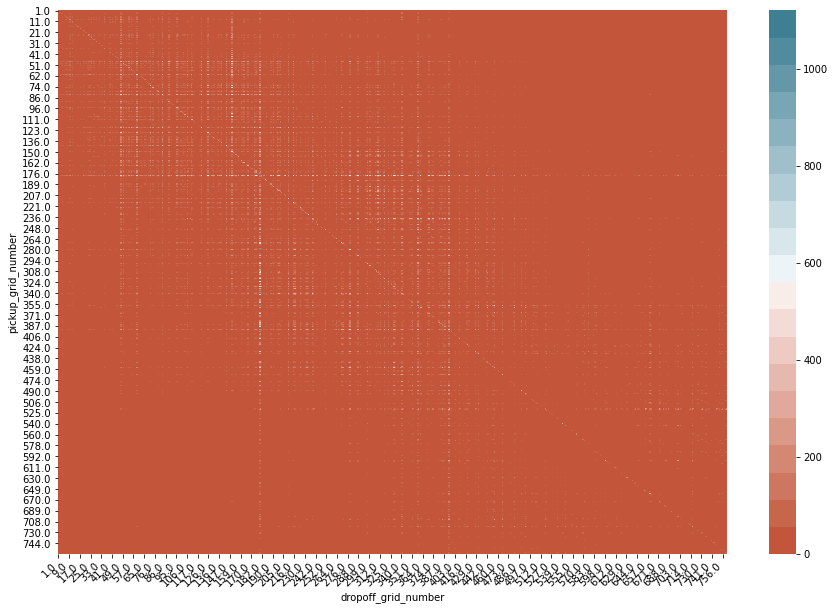

In [ ]:
# Zoom to visualize better, we used 500 records in accordance with 75% (third quartile)
plot(matrix.iloc[0:500,0:500],15,10)

This heatmap show us many things interesting like: there are strong lines on the Y axis, one of them is on the pickup number 180, this makes sense because 180 is a zone with many trips according to the graph showed lines above.
Clearly, we can see a diagonal line, showing that many trips were picked up and dropped off in the same zone.

## Heatmap to visualize the zones of pick up and dropoff by hours

In [ ]:
# Function filter matrix given the hour
def trips_by_hour(matriz,hour): # hours [0 to 23]
  if ((hour<0) | (hour>23)): # returns true if all digits otherwise false
    return print("Range of months is [0,23]")
  else:
    mf = matriz.loc[hour]
    return mf

In [ ]:
# Plotting matrix of the hour 20, 8PM
trips_in_hour=trips_by_hour(matrizbyhours,20)

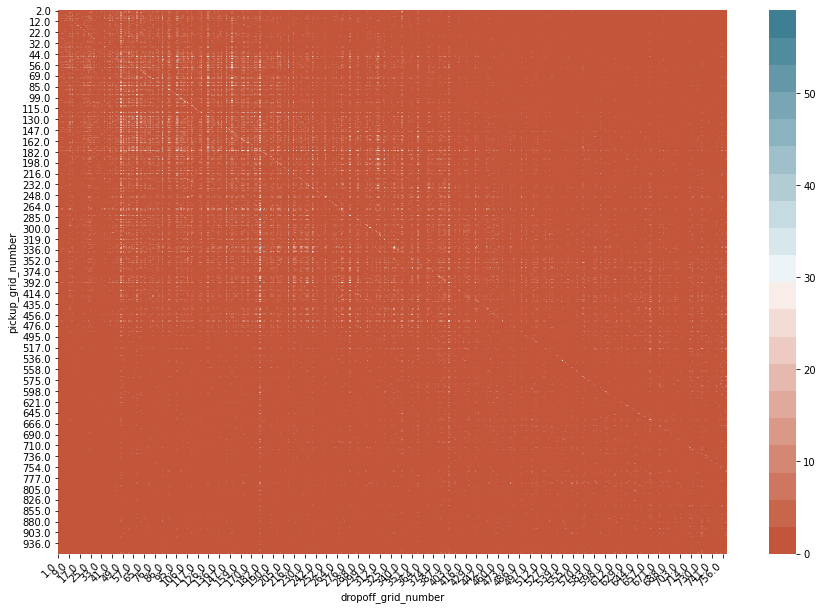

In [ ]:
# plotting 500 first rows
plot(trips_in_hour.iloc[:500,:500],15,10)

## Heatmap for each hour

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


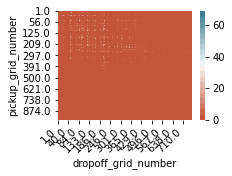

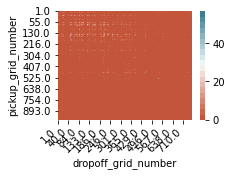

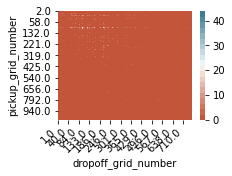

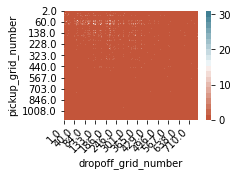

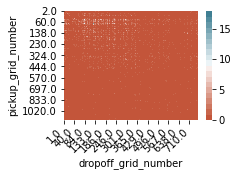

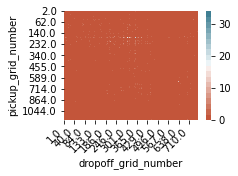

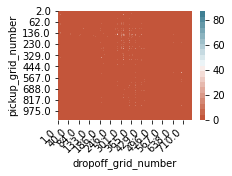

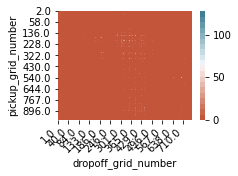

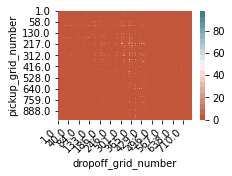

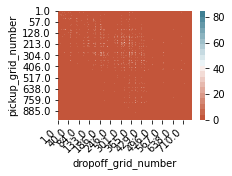

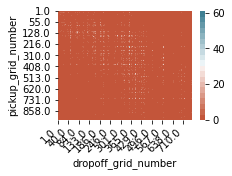

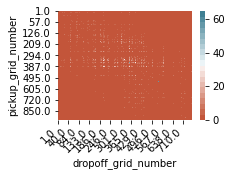

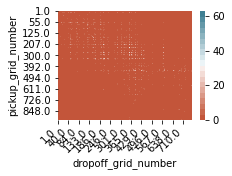

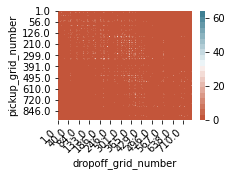

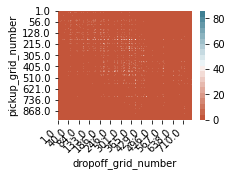

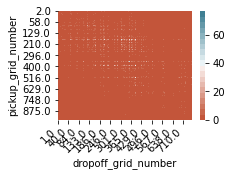

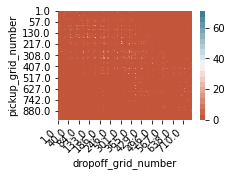

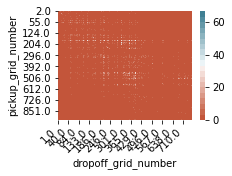

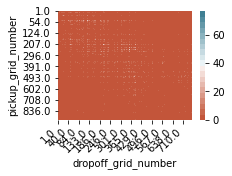

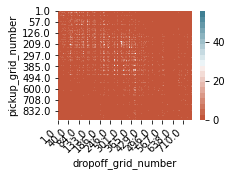

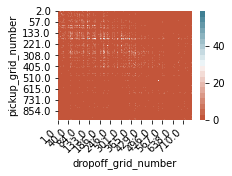

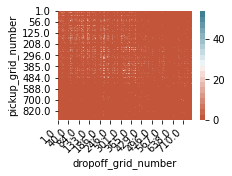

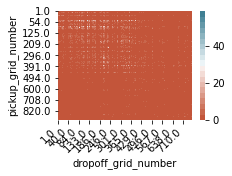

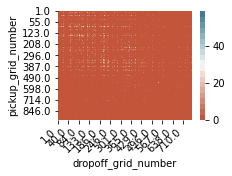

In [ ]:
# Plotting matrix by each hour from 1 hour to 23 hour
for i in range(24):
    trips_in_hour=trips_by_hour(matrizbyhours,i)
    plot(trips_in_hour.iloc[:500,:500],3,2)